# <span style='color:Red'> Quora Question Pairs Similarity </span>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p> Quora is a site where you can learn about anything and share what you've learned. It's a place where you can ask questions and get responses from people who have unique perspectives and answers. People will be able to learn from one another and have a greater understanding of the world as a result of this.</p>

<p> With over 100 million monthly users on Quora, it's no wonder that many individuals ask similar questions. Many inquiries with the same objective can lead to people spending more time looking for the best solution to their inquiry, as well as authors feeling obligated to respond to multiple variations of the same question. Canonical questions are valued by Quora because they provide a better experience for active seekers and writers, as well as more long-term value to both of these groups.</p>

__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source of Data: https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

# EDA

In [2]:
import warnings

warnings.filterwarnings("ignore")
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries to tune model, get different metric scores, and split data.
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#libraries to help with model building
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

In [3]:
import pandas as pd
train=pd.read_csv('/content/gdrive/MyDrive/Case study(Quora)/quora-question-pairs/train.csv')
test=pd.read_csv('/content/gdrive/MyDrive/Case study(Quora)/quora-question-pairs/test.csv')

In [4]:
train.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
train.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [6]:
test.isnull().sum()

test_id      0
question1    2
question2    4
dtype: int64

In [7]:
print('Number of train_point is-{} and Number of features/variables is-{}'.format(train.shape[0],train.shape[1]))

Number of train_point is-404290 and Number of features/variables is-6


In [8]:
train.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [9]:
data_nan = (train.isnull().sum() / len(train)) * 100
data_nan = data_nan.drop(data_nan[data_nan == 0].index).sort_values(ascending=False)[:10]
missing_data = pd.DataFrame({'Missing Ratio' :data_nan})
missing_data.head(5)

,Missing Ratio
question2,0.000495
question1,0.000247


Text(0.5, 1.0, 'Percent missing data by feature')

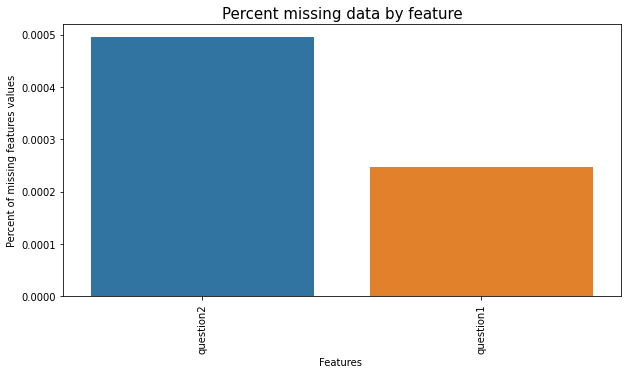

In [10]:
f, ax = plt.subplots(figsize=(10, 5))
plt.xticks(rotation='90')
sns.barplot(x=data_nan.index, y=data_nan)
plt.xlabel('Features ', fontsize=10)
plt.ylabel('Percent of missing features values', fontsize=10)
plt.title('Percent missing data by feature', fontsize=15)

In [11]:
def plot_categories(feature,title1):
    plt.figure(figsize=(15,8))
    count=train[feature].value_counts()
    sns.barplot(x=count[:15].values, y=count[:15].index)
    plt.title('(a)'+title1,fontsize=15)
    plt.xlabel('Counts', fontsize=13)
    plt.show()

In [12]:
def perc_on_bar(x):
    total_len = len(train[x]) # length of the column
    plt.figure(figsize=(15,7))
    ax = sns.countplot(train[x],palette='Paired')
    for p in ax.patches:
        per = '{:.1f}%'.format(100 * p.get_height()/total_len) 
        x = p.get_x() + p.get_width() / 2 - 0.10
        y = p.get_y() + p.get_height()          
        ax.annotate(per, (x, y), size = 12) # annotate the percantage 
    plt.show() # show the plot

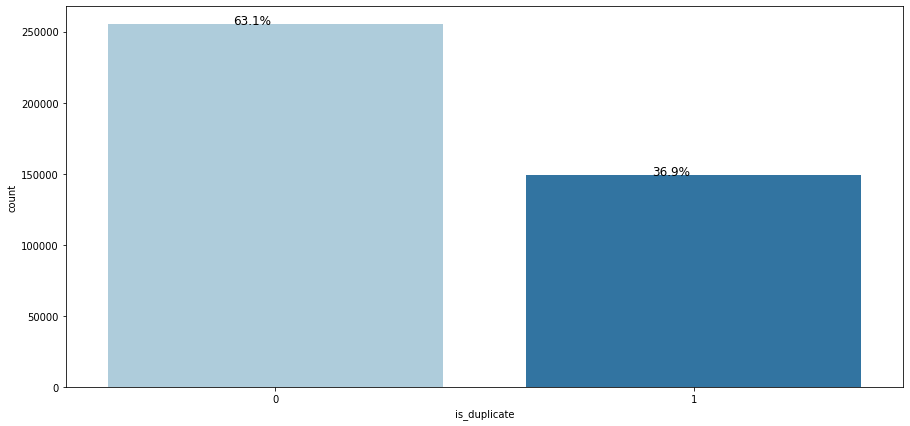

In [13]:
perc_on_bar('is_duplicate')

In [14]:
qids = pd.Series(train['qid1'].tolist() + train['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



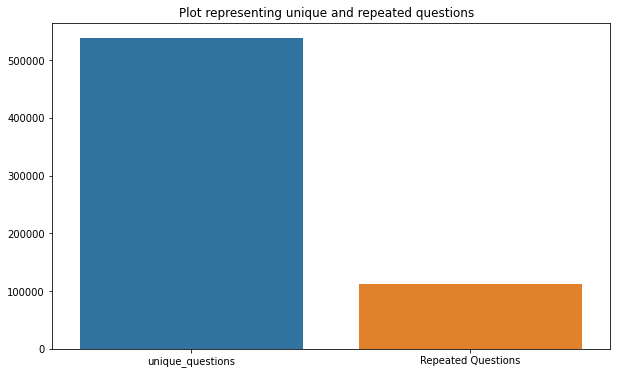

In [15]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

In [16]:
pair_duplicates = train[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - train.shape[0])

Number of duplicate questions 0


## Preprocessing

In [17]:
train['question1']=train['question1'].fillna('No Comment')
train['question2']=train['question2'].fillna('No Comment')
test['question1']=test['question1'].fillna('No Comment')
test['question2']=test['question2'].fillna('No Comment')

In [18]:
# Remove Emoji
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [19]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

In [20]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
from nltk.corpus import stopwords
from tqdm import tqdm
import re
stopwords = stopwords.words('english')
def preprocess(text_col,stopword):
    preprocessed = []
    for sentence in tqdm(text_col.values):
        # Replace "carriage return" with "space".
        sentence=str(sentence)
        sent = sentence.replace('\\r', ' ')
        # Replace "quotes" with "space".
        sent = sent.replace('\\"', ' ')
        # Replace "line feed" with "space".
        sent = sent.replace('\\n', ' ')
        # Replace characters between words with "space".
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        #remove stop words
        #decontraction
        sent=decontractions(sent)
        #Remove emoji
        sent=deEmojify(sent)
        if stopword:
            sent = ' '.join(e for e in sent.split() if e not in stopwords)
        else:
            sent = ' '.join(e for e in sent.split())
        # to lowercase
        preprocessed.append(sent.lower().strip())
    return preprocessed

In [22]:
train['question1']=preprocess(train['question1'],stopword=False)

100%|██████████| 404290/404290 [00:11<00:00, 35965.77it/s]


In [23]:
train['question2']=preprocess(train['question2'],stopword=False)

100%|██████████| 404290/404290 [00:11<00:00, 36064.64it/s]


In [24]:
test['question1']=preprocess(test['question1'],stopword=False)

100%|██████████| 2345796/2345796 [01:05<00:00, 35798.03it/s]


In [25]:
test['question2']=preprocess(test['question2'],stopword=False)

100%|██████████| 2345796/2345796 [01:05<00:00, 35849.55it/s]


## Question1

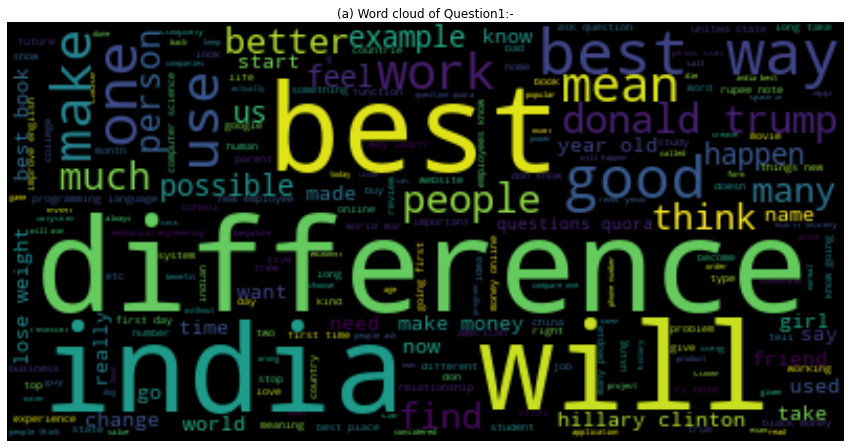

In [26]:
plt.figure(figsize = (15, 15))
plt.title("(a) Word cloud of Question1:-")
wc = WordCloud().generate(" ".join(train['question1'].astype(str)))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

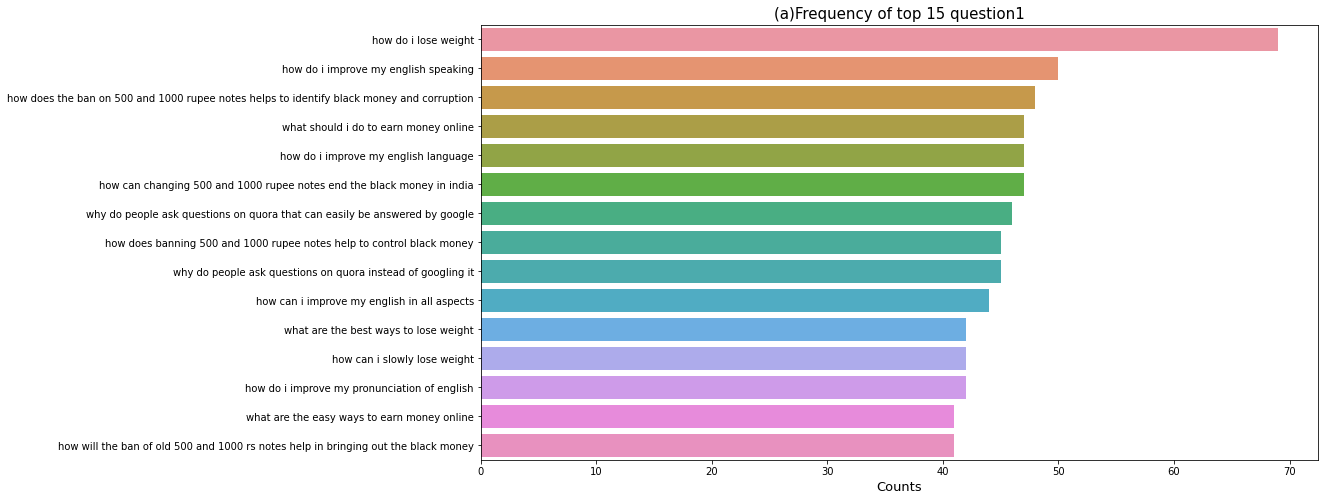

In [27]:
title1='Frequency of top 15 question1'
plot_categories('question1',title1)

## Question2

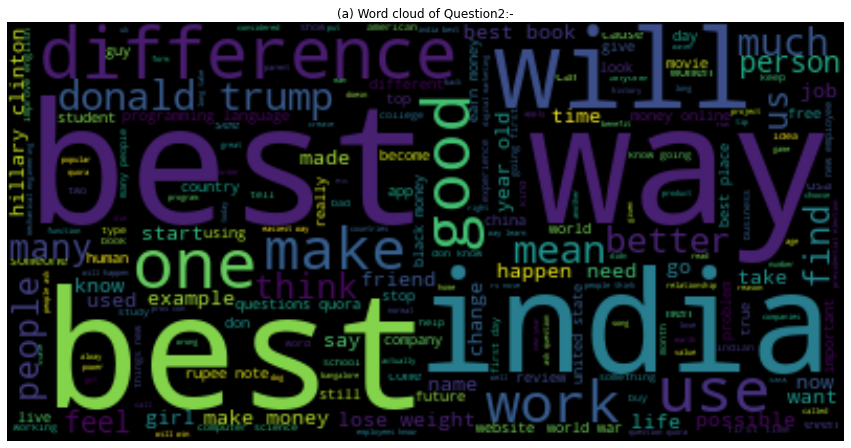

In [28]:
plt.figure(figsize = (15, 15))
plt.title("(a) Word cloud of Question2:-")
wc = WordCloud().generate(" ".join(train['question2'].astype(str)))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

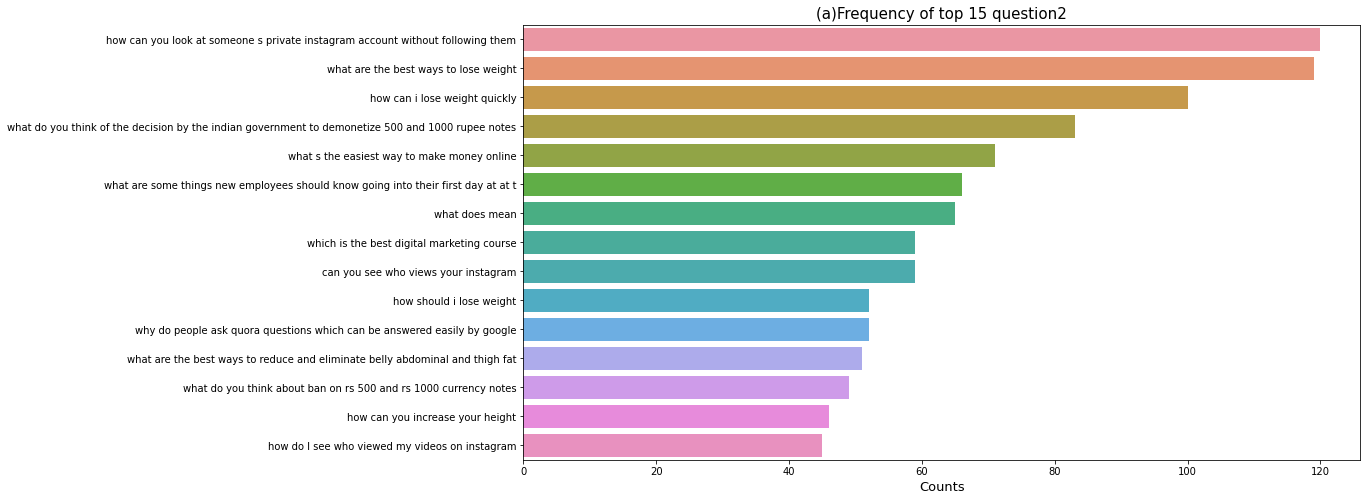

In [29]:
title1='Frequency of top 15 question2'
plot_categories('question2',title1)

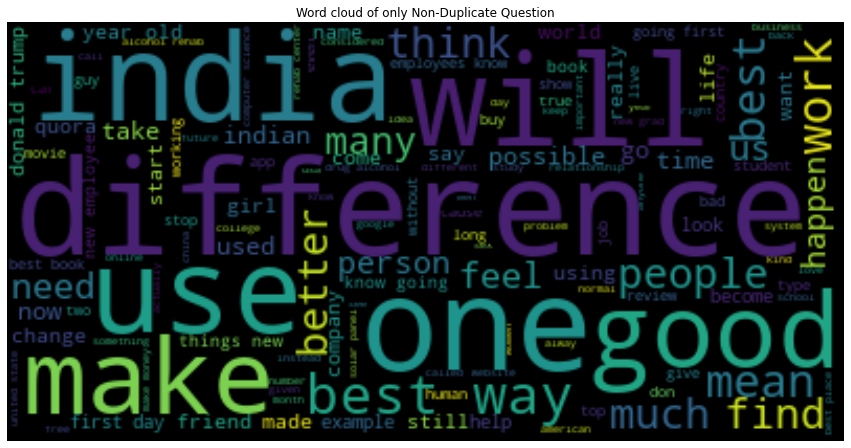

In [30]:
data1=train[train['is_duplicate']==0]
data=data1['question1']+data1['question2']
plt.figure(figsize = (15,15))
plt.title("Word cloud of only Non-Duplicate Question")
wc = WordCloud().generate(" ".join(data.astype(str)))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

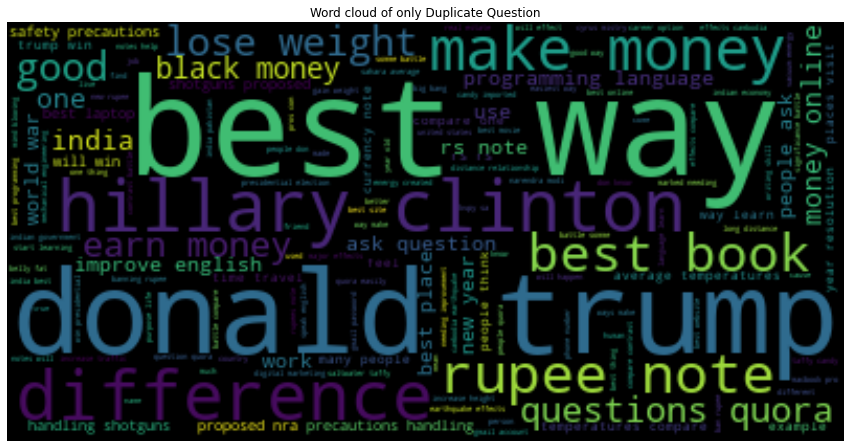

In [31]:
data1=train[train['is_duplicate']==1]
data=data1['question1']+data1['question2']
plt.figure(figsize = (15,15))
plt.title("Word cloud of only Duplicate Question")
wc = WordCloud().generate(" ".join(data.astype(str)))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [32]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [33]:
import nltk
from tqdm import tqdm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def generate_sentiment_scores(data):
    sid = SentimentIntensityAnalyzer()
    neg=[]
    pos=[]
    neu=[]
    comp=[]
    value=data['question1'].values+data['question2'].values
    for sentence in tqdm(value): 
        sentence_sentiment_score = sid.polarity_scores(sentence)
        comp.append(sentence_sentiment_score['compound'])
        neg.append(sentence_sentiment_score['neg'])
        pos.append(sentence_sentiment_score['pos'])
        neu.append(sentence_sentiment_score['neu'])
    return comp,neg,pos,neu

In [34]:
train['compound'],train['negative'],train['positive'],train['neutral']=generate_sentiment_scores(train)

100%|██████████| 404290/404290 [01:27<00:00, 4608.86it/s]


In [35]:
test['compound'],test['negative'],test['positive'],test['neutral']=generate_sentiment_scores(test)

100%|██████████| 2345796/2345796 [08:46<00:00, 4452.97it/s]


In [36]:
def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)

In [37]:
def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))

In [38]:
def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))

In [39]:
def add_feature(data):
    data['q1len'] = data['question1'].str.len() 
    data['q2len'] = data['question2'].str.len()
    data['q1_n_words'] = data['question1'].apply(lambda rows: len(rows.split(" ")))
    data['q2_n_words'] = data['question2'].apply(lambda rows: len(rows.split(" ")))
    data['word_Common'] = data.apply(normalized_word_Common, axis=1)
    data['word_Total'] = data.apply(normalized_word_Total, axis=1)
    data['word_share'] = data.apply(normalized_word_share, axis=1)
    return data

In [41]:
%%time
train=add_feature(train)

CPU times: user 24.6 s, sys: 209 ms, total: 24.8 s
Wall time: 24.8 s


In [42]:
%%time
test=add_feature(test)

CPU times: user 2min 19s, sys: 1.54 s, total: 2min 20s
Wall time: 2min 20s


In [43]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,compound,negative,positive,neutral,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.5267,0.000,0.161,0.839,65,56,14,12,11.0,23.0,0.478261
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0,0.3400,0.000,0.103,0.897,48,85,10,15,7.0,24.0,0.291667
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.5267,0.000,0.188,0.812,72,58,14,10,4.0,24.0,0.166667
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math is div...,0,-0.2484,0.118,0.076,0.805,48,59,11,13,0.0,20.0,0.000000
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,0.0000,0.000,0.000,1.000,73,38,13,7,4.0,20.0,0.200000


In [44]:
!pip3 install fuzzywuzzy

In [45]:
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz

In [46]:
from nltk.corpus import stopwords
nltk.download('stopwords')
STOP_WORDS = set(stopwords.words('english'))
SAFE_DIV=0.0001

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string


def extract_features(df):
    # preprocessing each question

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [48]:
%%time
train=extract_features(train)

token features...
fuzzy features..
CPU times: user 16min 43s, sys: 1.51 s, total: 16min 44s
Wall time: 16min 43s


In [49]:
%%time
test=extract_features(test)

token features...
fuzzy features..
CPU times: user 1h 46min 52s, sys: 13.8 s, total: 1h 47min 6s
Wall time: 1h 46min 56s


In [62]:
train.isnull().sum()

id                    0
qid1                  0
qid2                  0
question1             0
question2             0
is_duplicate          0
compound              0
negative              0
positive              0
neutral               0
q1len                 0
q2len                 0
q1_n_words            0
q2_n_words            0
word_Common           0
word_Total            0
word_share            0
cwc_min               0
cwc_max               0
csc_min               0
csc_max               0
ctc_min               0
ctc_max               0
last_word_eq          0
first_word_eq         0
abs_len_diff          0
mean_len              0
token_set_ratio       0
token_sort_ratio      0
fuzz_ratio            0
fuzz_partial_ratio    0
dtype: int64

In [61]:
test.isnull().sum()

test_id               0
question1             0
question2             0
compound              0
negative              0
positive              0
neutral               0
q1len                 0
q2len                 0
q1_n_words            0
q2_n_words            0
word_Common           0
word_Total            0
word_share            0
cwc_min               0
cwc_max               0
csc_min               0
csc_max               0
ctc_min               0
ctc_max               0
last_word_eq          0
first_word_eq         0
abs_len_diff          0
mean_len              0
token_set_ratio       0
token_sort_ratio      0
fuzz_ratio            0
fuzz_partial_ratio    0
dtype: int64

In [57]:
train['question1']=train['question1'].fillna('No Comment')
train['question2']=train['question2'].fillna('No Comment')
test['question1']=test['question1'].fillna('No Comment')
test['question2']=test['question2'].fillna('No Comment')

In [58]:
train.to_csv('/content/gdrive/MyDrive/Case study(Quora)/quora-question-pairs/train_preprocess.csv',index=False)

In [59]:
test.to_csv('/content/gdrive/MyDrive/Case study(Quora)/quora-question-pairs/test_preprocess.csv',index=False)

In [60]:
train=pd.read_csv('/content/gdrive/MyDrive/Case study(Quora)/quora-question-pairs/train_preprocess.csv')
test=pd.read_csv('/content/gdrive/MyDrive/Case study(Quora)/quora-question-pairs/test_preprocess.csv')

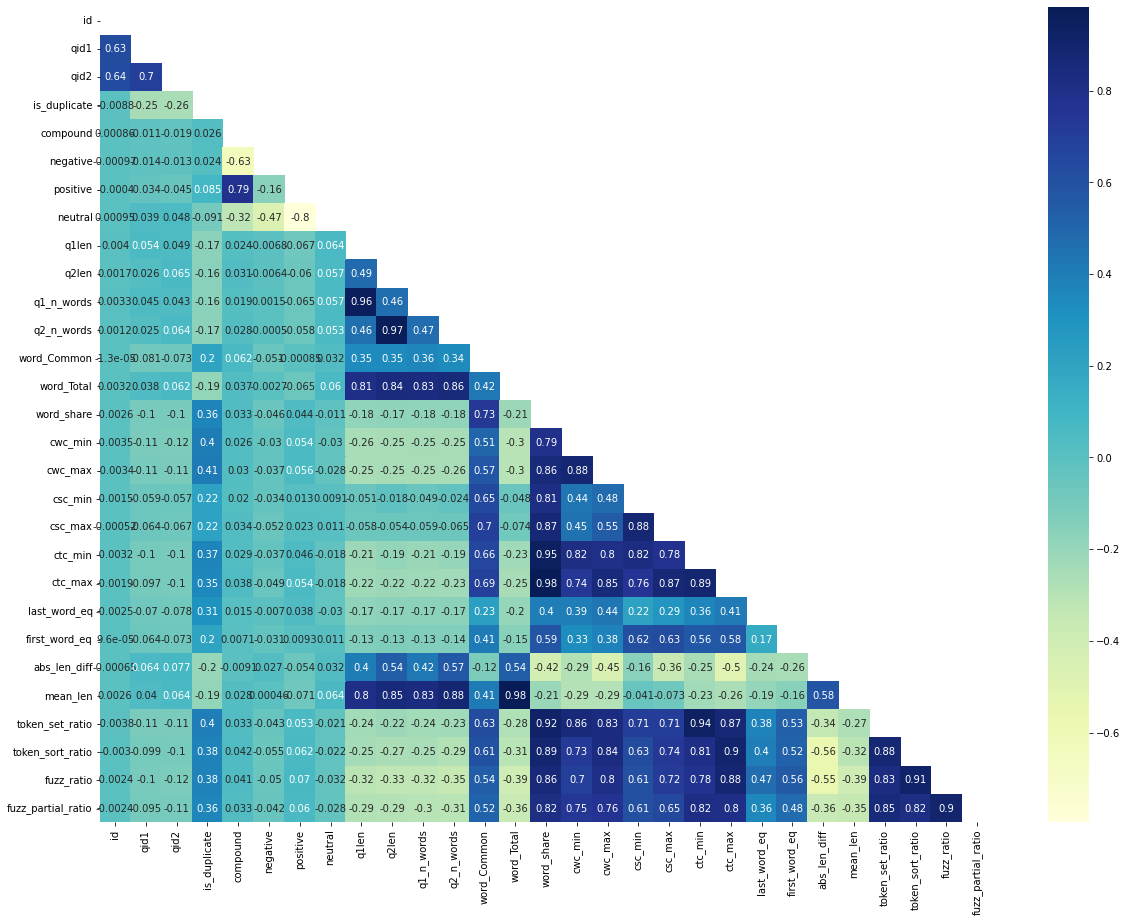

In [64]:
plt.figure(figsize=(20,15))
mask = np.triu(np.ones_like(train.corr()))
sns.heatmap(train.corr(),cmap="YlGnBu", annot=True, mask=mask)

In [65]:
Y=train['is_duplicate']
X=train.drop(['id','qid1','qid2','is_duplicate'],axis=1)

In [66]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [67]:
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(303217, 27) (303217,)
(101073, 27) (101073,)


In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
def text_encoding(train,test,test_final,type_val,params):
    if type_val == 'BOW':
        vectorizer = CountVectorizer(ngram_range = params[0],min_df=1,max_df=25,max_features=params[1])  
    else :
        vectorizer=TfidfVectorizer(ngram_range = params[0],min_df=1,max_df=25,max_features=params[1])
    train_transform = vectorizer.fit_transform(train)
    test_final_transform=vectorizer.transform(test_final)
    test_transform = vectorizer.transform(test)
    return train_transform,test_transform,test_final_transform

In [69]:
%%time
train_bow_q1,test_bow_q1,test_final_bow_q1= text_encoding(X_train['question1'],X_test['question1'],test['question1'],'TFIDF',((1,4),50000))
print(train_bow_q1.shape,test_bow_q1.shape,test_final_bow_q1.shape)

(303217, 50000) (101073, 50000) (2345796, 50000)
CPU times: user 1min 34s, sys: 311 ms, total: 1min 35s
Wall time: 1min 34s


In [70]:
%%time
train_bow_q2,test_bow_q2,test_final_bow_q2= text_encoding(X_train['question2'],X_test['question2'],test['question2'],'TFIDF',((1,4),50000))
print(train_bow_q2.shape,test_bow_q2.shape,test_final_bow_q2.shape)

(303217, 50000) (101073, 50000) (2345796, 50000)
CPU times: user 1min 36s, sys: 320 ms, total: 1min 36s
Wall time: 1min 36s


In [71]:
from sklearn.preprocessing import Normalizer
def data_Normalizer(train,test,test_final):
    norm=Normalizer()
    norm.fit(train)
    train_norm=norm.transform(train)
    test_norm=norm.transform(test)
    test_final_norm=norm.transform(test_final)
    return train_norm,test_norm,test_final_norm

In [72]:
train_q1_len,test_q1_len,test_final_q1_len=data_Normalizer(X_train['q1len'].values.reshape(-1,1),X_test['q1len'].values.reshape(-1,1),test['q1len'].values.reshape(-1,1))

In [73]:
train_q2_len,test_q2_len,test_final_q2_len=data_Normalizer(X_train['q2len'].values.reshape(-1,1),X_test['q2len'].values.reshape(-1,1),test['q2len'].values.reshape(-1,1))

In [74]:
train_q1_n,test_q1_n,test_final_q1_n=data_Normalizer(X_train['q1_n_words'].values.reshape(-1,1),X_test['q1_n_words'].values.reshape(-1,1),test['q1_n_words'].values.reshape(-1,1))

In [75]:
train_q2_n,test_q2_n,test_final_q2_n=data_Normalizer(X_train['q2_n_words'].values.reshape(-1,1),X_test['q2_n_words'].values.reshape(-1,1),test['q1_n_words'].values.reshape(-1,1))

In [76]:
train_common,test_common,test_final_common=data_Normalizer(X_train['word_Common'].values.reshape(-1,1),X_test['word_Common'].values.reshape(-1,1),test['word_Common'].values.reshape(-1,1))

In [77]:
train_total,test_total,test_final_total=data_Normalizer(X_train['word_Total'].values.reshape(-1,1),X_test['word_Total'].values.reshape(-1,1),test['word_Total'].values.reshape(-1,1))

In [78]:
train_share,test_share,test_final_share=data_Normalizer(X_train['word_share'].values.reshape(-1,1),X_test['word_share'].values.reshape(-1,1),test['word_share'].values.reshape(-1,1))

In [79]:
train_cwc_min,test_cwc_min,test_final_cwc_min=data_Normalizer(X_train['cwc_min'].values.reshape(-1,1),X_test['cwc_min'].values.reshape(-1,1),test['cwc_min'].values.reshape(-1,1))

In [80]:
train_cwc_max,test_cwc_max,test_final_cwc_max=data_Normalizer(X_train['cwc_max'].values.reshape(-1,1),X_test['cwc_max'].values.reshape(-1,1),test['cwc_max'].values.reshape(-1,1))

In [81]:
train_csc_min,test_csc_min,test_final_csc_min=data_Normalizer(X_train['csc_min'].values.reshape(-1,1),X_test['csc_min'].values.reshape(-1,1),test['csc_min'].values.reshape(-1,1))

In [82]:
train_csc_max,test_csc_max,test_final_csc_max=data_Normalizer(X_train['csc_max'].values.reshape(-1,1),X_test['csc_max'].values.reshape(-1,1),test['csc_max'].values.reshape(-1,1))

In [84]:
train_ctc_min,test_ctc_min,test_final_ctc_min=data_Normalizer(X_train['ctc_min'].values.reshape(-1,1),X_test['ctc_min'].values.reshape(-1,1),test['ctc_min'].values.reshape(-1,1))

In [83]:
train_ctc_max,test_ctc_max,test_final_ctc_max=data_Normalizer(X_train['ctc_max'].values.reshape(-1,1),X_test['ctc_max'].values.reshape(-1,1),test['ctc_max'].values.reshape(-1,1))

In [85]:
train_last,test_last,test_final_last=data_Normalizer(X_train['last_word_eq'].values.reshape(-1,1),X_test['last_word_eq'].values.reshape(-1,1),test['last_word_eq'].values.reshape(-1,1))

In [86]:
train_first,test_first,test_final_first=data_Normalizer(X_train['first_word_eq'].values.reshape(-1,1),X_test['first_word_eq'].values.reshape(-1,1),test['first_word_eq'].values.reshape(-1,1))

In [87]:
train_abs,test_abs,test_final_abs=data_Normalizer(X_train['abs_len_diff'].values.reshape(-1,1),X_test['abs_len_diff'].values.reshape(-1,1),test['abs_len_diff'].values.reshape(-1,1))

In [88]:
train_mean,test_mean,test_final_mean=data_Normalizer(X_train['mean_len'].values.reshape(-1,1),X_test['mean_len'].values.reshape(-1,1),test['mean_len'].values.reshape(-1,1))

In [89]:
train_token_set,test_token_set,test_final_token_set=data_Normalizer(X_train['token_set_ratio'].values.reshape(-1,1),X_test['token_set_ratio'].values.reshape(-1,1),test['token_set_ratio'].values.reshape(-1,1))

In [90]:
train_token_sort,test_token_sort,test_final_token_sort=data_Normalizer(X_train['token_sort_ratio'].values.reshape(-1,1),X_test['token_sort_ratio'].values.reshape(-1,1),test['token_sort_ratio'].values.reshape(-1,1))

In [95]:
train_fuzz_ratio,test_fuzz_ratio,test_final_fuzz_ratio=data_Normalizer(X_train['fuzz_ratio'].values.reshape(-1,1),X_test['fuzz_ratio'].values.reshape(-1,1),test['fuzz_ratio'].values.reshape(-1,1))

In [96]:
train_fuzz_p_ratio,test_fuzz_p_ratio,test_final_fuzz_p_ratio=data_Normalizer(X_train['fuzz_partial_ratio'].values.reshape(-1,1),X_test['fuzz_partial_ratio'].values.reshape(-1,1),test['fuzz_partial_ratio'].values.reshape(-1,1))

In [ ]:
test_final_cwc_min,test_final_cwc_max,test_final_csc_min,test_final_csc_max,test_final_ctc_min,test_final_csc_max,test_final_ctc_max,test_final_last,test_final_first,test_final_abs,test_final_mean,test_final_token_set,test_final_token_sort,test_final_fuzz_ratio,test_final_cwc_min

In [97]:
from scipy.sparse import hstack
train_s=hstack((train_bow_q1,train_bow_q2,train_q1_len,train_q2_len,train_q1_n,train_q2_n,train_common,train_total,train_share,train_cwc_min,train_cwc_max,train_csc_min,train_csc_max,train_ctc_min,train_csc_max,train_ctc_max,train_last,train_first,train_abs,train_mean,train_token_set,train_token_sort,train_fuzz_ratio,train_cwc_min)).tocsr().astype('float32')
test_s=hstack((test_bow_q1,test_bow_q2,test_q1_len,test_q2_len,test_q1_n,test_q2_n,test_common,test_total,test_share,test_cwc_min,test_cwc_max,test_csc_min,test_csc_max,test_ctc_min,test_csc_max,test_ctc_max,test_last,test_first,test_abs,test_mean,test_token_set,test_token_sort,test_fuzz_ratio,test_cwc_min)).tocsr().astype('float32')
test_final_s=hstack((test_final_bow_q1,test_final_bow_q2,test_final_q1_len,test_final_q2_len,test_final_q1_n,test_final_q2_n,test_final_common,test_final_total,test_final_share,test_final_cwc_min,test_final_cwc_max,test_final_csc_min,test_final_csc_max,test_final_ctc_min,test_final_csc_max,test_final_ctc_max,test_final_last,test_final_first,test_final_abs,test_final_mean,test_final_token_set,test_final_token_sort,test_final_fuzz_ratio,test_final_cwc_min)).tocsr().astype('float32')

In [98]:
print("Final Train Shape",train_s.shape,Y_train.shape)
print("Final Test Shape",test_s.shape,Y_test.shape)
print("Test shape",test_final_s.shape)

Final Train Shape (303217, 100022) (303217,)
Final Test Shape (101073, 100022) (101073,)
Test shape (2345796, 100022)


In [99]:
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(test_s)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier)
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from tqdm import tqdm
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import RidgeClassifier,LassoCV,RidgeClassifierCV
from sklearn.metrics import mean_squared_error, make_scorer,mean_squared_log_error

# Logistic Regression with hyperparameter tuning

For values of alpha =  1e-10 The log loss is: 0.4941524284705995
For values of alpha =  1e-09 The log loss is: 0.4978428130616873
For values of alpha =  1e-08 The log loss is: 0.5007423486401854
For values of alpha =  1e-07 The log loss is: 0.48295954294824184
For values of alpha =  1e-06 The log loss is: 0.4546614816106693
For values of alpha =  1e-05 The log loss is: 0.4549027453516142
For values of alpha =  0.0001 The log loss is: 0.5351988958126757
For values of alpha =  0.001 The log loss is: 0.5672126910872346
For values of alpha =  0.01 The log loss is: 0.5745527277330601
For values of alpha =  0.1 The log loss is: 0.583492136824087
For values of alpha =  1 The log loss is: 0.6257686440377246
For values of alpha =  10 The log loss is: 0.6446402312928186
For values of alpha =  100 The log loss is: 0.6355799128487354
For values of alpha =  1000 The log loss is: 0.6346031582734878
For values of alpha =  10000 The log loss is: 0.6345018638617927


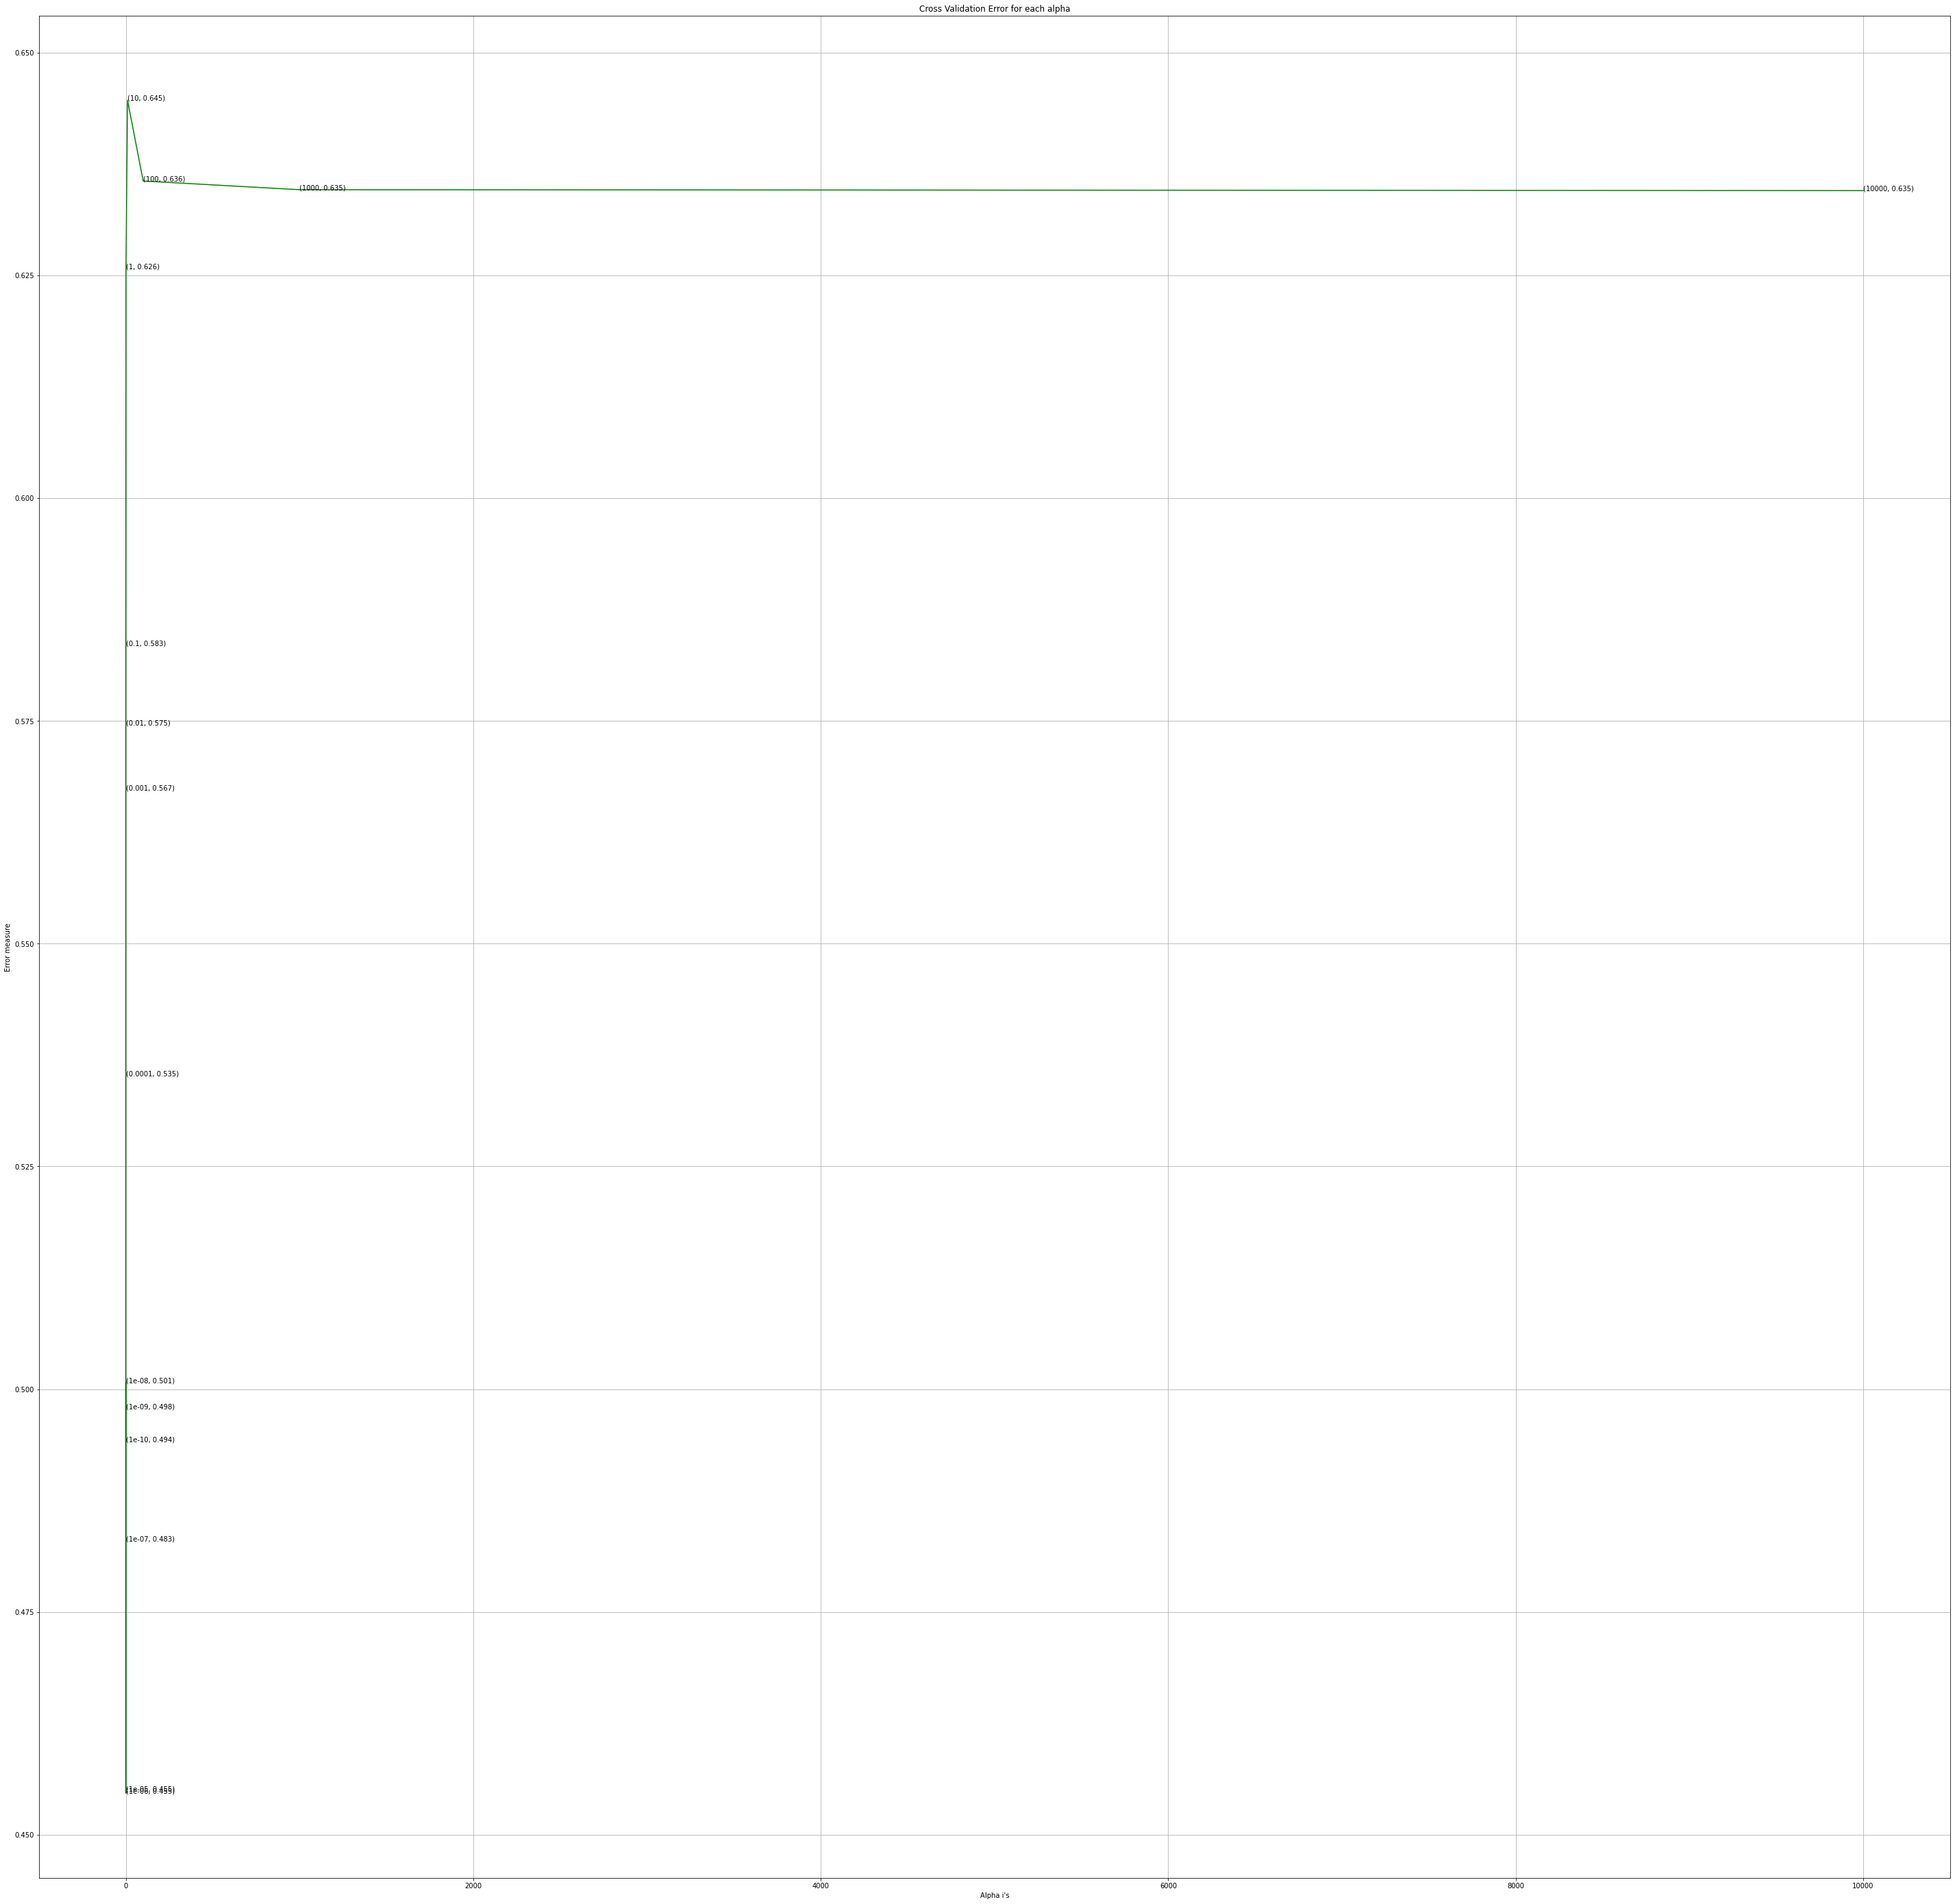

For values of best alpha =  1e-06 The train log loss is: 0.3482404206244377
For values of best alpha =  1e-06 The test log loss is: 0.4546614816106693
Total number of data points : 101073


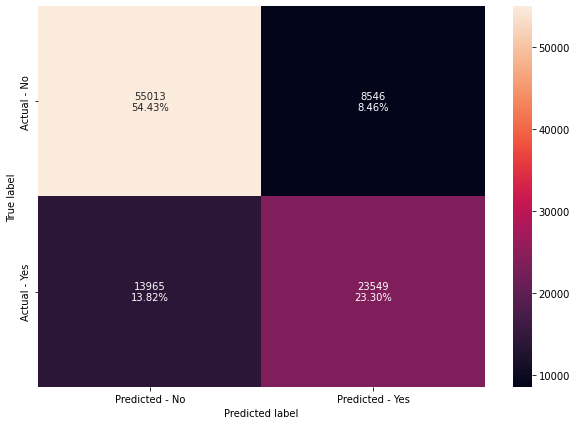

In [113]:
from sklearn.calibration import CalibratedClassifierCV
alpha = [10 ** x for x in range(-10, 5)]
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_s, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_s, Y_train)
    predict_y = sig_clf.predict_proba(test_s)
    log_error_array.append(log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_s, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_s, Y_train)

predict_y = sig_clf.predict_proba(train_s)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_s)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
make_confusion_matrix(sig_clf,Y_test,labels=[1, 0])

In [115]:
Y_pred=sig_clf.predict(test_final_s)

In [116]:
submission=pd.read_csv('/content/gdrive/MyDrive/Case study(Quora)/quora-question-pairs/sample_submission.csv')
submission.head()

,test_id,is_duplicate
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [117]:
submission['is_duplicate']=Y_pred

In [118]:
submission.head()

,test_id,is_duplicate
0,0,0
1,1,0
2,2,0
3,3,0
4,4,1


In [120]:
submission.to_csv('submission.csv',index=False)

# XGBoost

In [104]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(train_s, label=Y_train)
d_test = xgb.DMatrix(test_s, label=Y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(train_s,Y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.688964	valid-logloss:0.688993
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.654981	valid-logloss:0.655244
[20]	train-logloss:0.631393	valid-logloss:0.631827
[30]	train-logloss:0.614596	valid-logloss:0.615166
[40]	train-logloss:0.602426	valid-logloss:0.603104
[50]	train-logloss:0.593493	valid-logloss:0.594259
[60]	train-logloss:0.58686	valid-logloss:0.587703
[70]	train-logloss:0.581898	valid-logloss:0.58282
[80]	train-logloss:0.57814	valid-logloss:0.579137
[90]	train-logloss:0.575265	valid-logloss:0.576331
[100]	train-logloss:0.573048	valid-logloss:0.574168
[110]	train-logloss:0.571319	valid-logloss:0.572492
[120]	train-logloss:0.56995	valid-logloss:0.571177
[130]	train-logloss:0.568864	valid-logloss:0.570139
[140]	train-logloss:0.567994	valid-logloss:0.569316
[150]	train-logloss:0.567277	valid-logloss:0.568649
[160]	train-logloss:0.566694	val

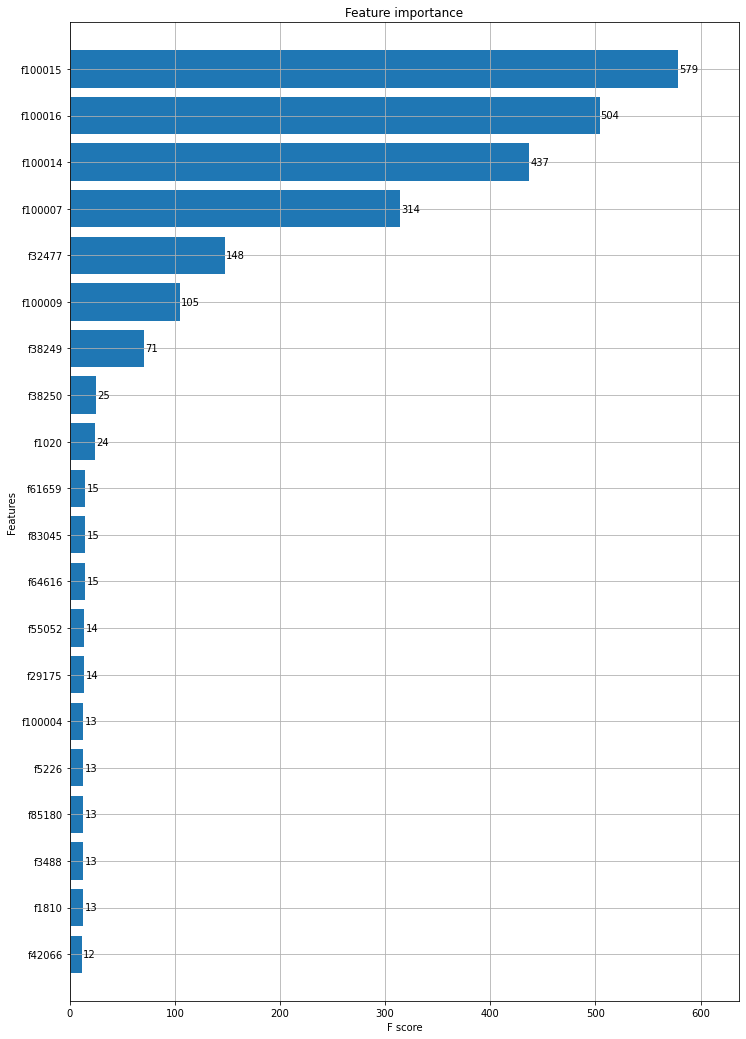

In [112]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(bst, max_num_features=20, height=0.8, ax=ax)
plt.show()

# Linear SVM with hyperparameter tuning

For values of alpha =  1e-10 The log loss is: 0.5064920379954755
For values of alpha =  1e-09 The log loss is: 0.5100122588384497
For values of alpha =  1e-08 The log loss is: 0.5059143034605138
For values of alpha =  1e-07 The log loss is: 0.497319955753615
For values of alpha =  1e-06 The log loss is: 0.48562472607120855
For values of alpha =  1e-05 The log loss is: 0.5001889516641825
For values of alpha =  0.0001 The log loss is: 0.5808414457993596
For values of alpha =  0.001 The log loss is: 0.6120325316527142
For values of alpha =  0.01 The log loss is: 0.6124456672654995
For values of alpha =  0.1 The log loss is: 0.6594987455093164
For values of alpha =  1 The log loss is: 0.6595834919447361
For values of alpha =  10 The log loss is: 0.6595834919603479
For values of alpha =  100 The log loss is: 0.6595834919603479
For values of alpha =  1000 The log loss is: 0.6595834919603479
For values of alpha =  10000 The log loss is: 0.6595834919411238


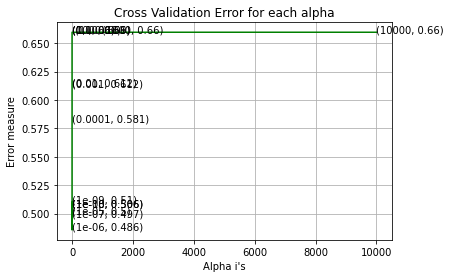

For values of best alpha =  1e-06 The train log loss is: 0.40483512141108485
For values of best alpha =  1e-06 The test log loss is: 0.48562472607120855
Total number of data points : 101073


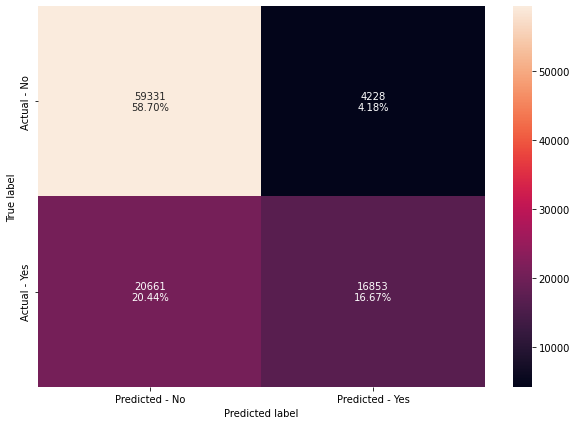

In [105]:
alpha = [10 ** x for x in range(-10, 5)]
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(train_s, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_s, Y_train)
    predict_y = sig_clf.predict_proba(test_s)
    log_error_array.append(log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(train_s, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_s, Y_train)

predict_y = sig_clf.predict_proba(train_s)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_s)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
make_confusion_matrix(sig_clf,Y_test,labels=[1, 0])